In [1]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Doing FSS analysis via the method nonlinear least squares

### Preparation
The following modules are required

In [3]:
from liquidity.features import compute_aggregate_features

from market_impact.util.utils import bin_data_into_quantiles, smooth_outliers
from market_impact.response_functions.price_response_functions import compute_conditional_impact

In [4]:
BIN_SIZE = list(range(1, 150))
OBSERVATION_WINDOWS = [5, 10, 20, 50, 100]

The following are special modules for conducting the FSS by method of LS.

In [5]:
from market_impact.response_functions.fss import find_shape_parameters, find_scale_factors, transform

### Dataset

We first prepare the data. Each entry of the orderbook data correpsonds to a single event of type $\pi$ (trade execution, limit order deposit or cancellation) in the orderbook for a given asset (say a stock, APPL or TSLA).

In [6]:
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..')
data_dir = os.path.join(root_dir, 'dataset', 'MO_sample')
filename = "APPLE-2017-NEW.csv" # APPLE Example
stock_file_path = os.path.join(data_dir, filename)
tsla_orderbook_states = pd.read_csv(stock_file_path)
display(tsla_orderbook_states)

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,bid_queue_size_mean,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,762.184840,0.000,0.000,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,762.184840,-0.010,0.010,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,762.184840,0.010,0.010,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,762.184840,0.000,0.000,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,762.184840,0.000,0.000,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633973,6730,2017-12-29 14:59:22.595997049,1,ASK,REMOVE,True,169.99,200,169.99,169.98,...,725.867637,0.005,0.005,0.01,2017-12-29,0.030568,1452499,6735,0.258699,200
2633974,6731,2017-12-29 14:59:26.825179397,1,ASK,REMOVE,True,170.00,1200,170.00,169.98,...,725.867637,0.005,0.005,0.02,2017-12-29,0.030568,1452499,6735,1.552195,1200
2633975,6732,2017-12-29 14:59:58.621436793,-1,BID,UPDATE,True,169.99,300,170.00,169.99,...,725.867637,0.000,-0.000,0.01,2017-12-29,0.030568,1452499,6735,0.413298,-300
2633976,6733,2017-12-29 14:59:58.621758027,-1,BID,REMOVE,True,169.99,205,170.00,169.99,...,725.867637,-0.010,0.010,0.01,2017-12-29,0.030568,1452499,6735,0.282421,-205


 We first coarse-grain this data into different bin sizes, we marginalize over microscopic degrees of freedom in the system to yield an effective coarse-grained description at long distances.

In [7]:
aggregate_features = compute_aggregate_features(tsla_orderbook_states, BIN_SIZE)
display(aggregate_features)

,event_timestamp,midprice,sign,signed_volume,vol_imbalance,sign_imbalance,daily_R1,daily_vol,daily_num,T
0,2017-01-03 10:30:00.544161131,115.695,1,100,100,1,0.004271,1398089,6170,1
1,2017-01-03 10:30:02.758712611,115.695,-1,-153,-153,-1,0.004271,1398089,6170,1
2,2017-01-03 10:30:02.852790059,115.685,1,200,200,1,0.004271,1398089,6170,1
3,2017-01-03 10:30:04.539218241,115.695,1,100,100,1,0.004271,1398089,6170,1
4,2017-01-03 10:30:07.865732286,115.695,1,10,10,1,0.004271,1398089,6170,1
...,...,...,...,...,...,...,...,...,...,...
17673,2017-12-29 14:13:10.007904919,169.965,1,700,-1029,9,0.030568,1452499,6735,149
17674,2017-12-29 14:21:47.238059427,170.005,-1,-17,-12965,-27,0.030568,1452499,6735,149
17675,2017-12-29 14:35:36.652311807,169.945,1,3,-5659,1,0.030568,1452499,6735,149
17676,2017-12-29 14:44:14.692711793,169.985,-1,-71,-9528,-21,0.030568,1452499,6735,149


### Data normalization

From aggregate features, we can then compute conditional aggregate impact. Each line of our aggregate feature data will be converted into an aggregate impact dataframe consisting of three values {system size T, temperature x, observable A}. In our case these correspond to T, orderflow imbalance and aggregate returns respectively.

All data are automatically rescaled in preparation for a finite-size scaling. In particular, the temperature $\Delta V$ and observable $R$ are rescaled each day by their corresponding values of $\mathcal{R}(1)$ and either the average queue volume $\overline{V}_{\mathrm{best}}$ or  daily volume  $V_D$  that represent constants of unit dimension that define a characteristic length scale. A similar rescaling works well for different asset classes.

In [8]:
# Compute data for susceptibility – conditional aggregate impact
normalized_data = compute_conditional_impact(aggregate_features)
display(normalized_data)

,T,vol_imbalance,R
0,1,0.000072,0.000000
1,1,-0.000109,-2.341556
2,1,0.000143,2.341556
3,1,0.000072,0.000000
4,1,0.000007,0.000000
...,...,...,...
17673,149,-0.000708,1.308561
17674,149,-0.008926,-1.962842
17675,149,-0.003896,1.308561
17676,149,-0.006560,-0.163570


### $1.$ Determine shape parameters $\alpha$ and $\beta$
In order to determine the shape paremeters, the shape, the scaling form $R(\Delta V^\prime, T)$ is fitted for $\textit{all}$ $T$s using the scaling form Eq. X.

In [9]:
alpha, beta = find_shape_parameters(normalized_data)
print(f'alpha: {alpha}')
print(f'beta: {beta}')

alpha: 0.4997307793900398
beta: 3.30315454310339


### $2.$ Map out scale factors $V_T$ and $R_T$ and determine thier behaviour.

In order to determine the scaling hehaviour and rescaling exponents $\chi$ and $\varkappa$ that follow, the shape of RN(\Delta V, T) is fitted for $\textit{each}$ T using the scaling form Eq. X with the scaling function $\mathscr{F}(x)$ given by Eq. X whilst keeping the preveously found values values of $\alpha$ nad $\beta$ constant. Note that the fitting of the aggregate impact curve that yield  $R_T, Q_T$ for each T did not impose any assumptions on their scaling.

In [10]:
RN_series, QN_series, RN_fit_object, QN_fit_object, fit_results_per_lag = find_scale_factors(normalized_data, alpha=alpha, beta=beta)

[]

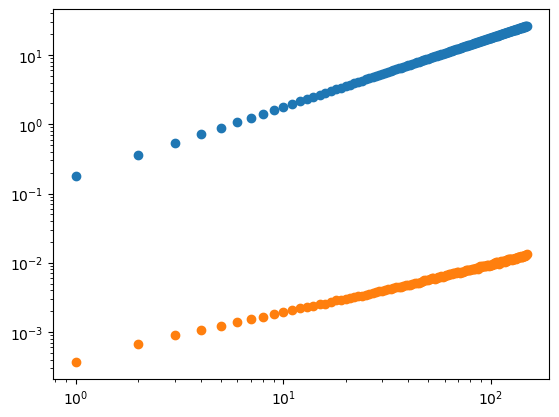

In [11]:
# Plot scale factors RN and QN
plt.scatter(RN_series['x_values'],RN_series['y_values'])
plt.scatter(QN_series['x_values'],QN_series['y_values'])
plt.loglog()

#### $2.2.$ From mapped out scale factors, determine scaling exponents $\chi$ and $\varkappa$

In [12]:
chi = RN_fit_object.powerlaw.params.alpha
kappa = QN_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.9974994824128488
0.7399612469302459



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 11.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.17912573206319443
alpha = 0.9974994824128488

Goodness of fit to data;
D = 0.007194244604316547
bic = -1421.0749135837402
mape = 0.052013822952289644
Adjusted R-squared = 0.9999993366887914



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 11.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.00031431802455832684
alpha = 0.7399612469302459

Goodness of fit to data;
D = 0.02877697841726619
bic = -2418.1899484246787
mape = 1.7683231401634674
Adjusted R-squared = 0.9973014387664262




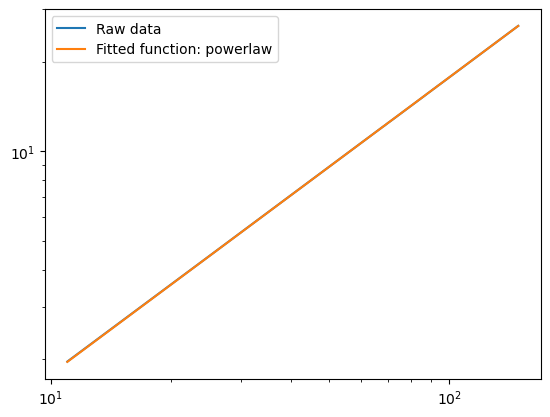

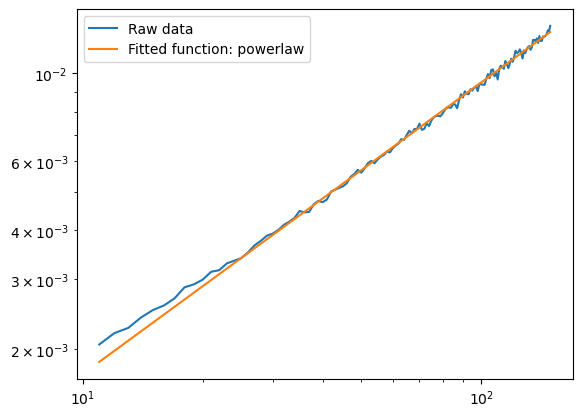

In [13]:
# Fit results
RN_fit_object.powerlaw.fit_results()
QN_fit_object.powerlaw.fit_results()
RN_fit_object.powerlaw.plot_fit()
QN_fit_object.powerlaw.plot_fit()

In [14]:
# Compare against alternative heavy-tailed hypothesis
print("Power law vs. powerlaw_with_exp_svf")
R, p = RN_fit_object.function_compare("powerlaw", "exponential_function")
R, p = RN_fit_object.function_compare("powerlaw", "lognormal_function")

RN_fit_object.return_all_fitting_results()

Power law vs. powerlaw_with_exp_svf


,name,xmin_index,xmin,fitting param,D,bic,mape,adjusted r-squared
0,powerlaw,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.1791257...",0.0072,-1421.0749,0.0520,1.0000
1,OLS,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.1797282...",0.0072,-1355.8416,0.0335,1.0000
2,GeneralisedRegression,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.1797282...",0.0072,-1355.8416,0.0335,1.0000
3,RobustRegression,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.1797244...",0.0072,-1355.3826,0.0334,1.0000
4,exponential_function,10,11.0,"{'param_names': ['beta', 'lambda_'], 'beta': 4...",0.1511,126.8364,18.6633,0.9545
5,lognormal_function,10,11.0,"{'param_names': ['mu', 'sigma'], 'mu': 0.0, 's...",1.0000,782.8804,100.0000,-4.1027


### $3.1$ Plot the scaling law before and after the transforming

We can now substitute the found emeprical scaling laws for RN and QN and use this law fit the final shape parameters $\alpha$ and $\beta$, and rescaling exponents $\chi$ and $\varkappa$.

In [15]:
from market_impact.response_functions.fss import fit_scaling_law
from market_impact.response_functions.functional_form import scaling_function, scaling_law

# Plot final rescaled functions
OBSERVATION_WINDOWS = [x for x in OBSERVATION_WINDOWS if x in QN_series['x_values'].values]

# Smooth data for plotting purposes
smoothed_data = smooth_outliers(normalized_data.copy())

fit_param = {}
for T in OBSERVATION_WINDOWS:
    data = normalized_data[normalized_data['T']==T][["T", "vol_imbalance", "R"]]
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    binned_data = bin_data_into_quantiles(data, q=len(BIN_SIZE), duplicates="drop")

    T_values = binned_data['T'].values
    vol_imbalance_values = binned_data['vol_imbalance'].values
    R_values = binned_data['R'].values

    params = fit_scaling_law(T_values, vol_imbalance_values, R_values)
    fit_param[T] = params

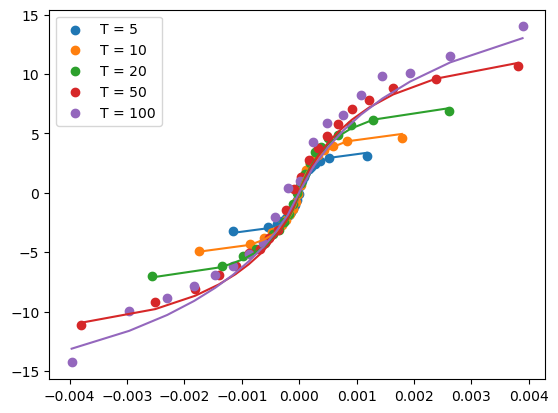

In [16]:

for T, param in fit_param.items():
    params = fit_param[T]
    data = smoothed_data[smoothed_data['T']==T][["vol_imbalance", "T", "R"]]
    binned_data = bin_data_into_quantiles(data, q=21, duplicates="drop")

    T_values = binned_data['T'].values
    vol_imbalance_values = binned_data['vol_imbalance'].values
    R_values = binned_data['R'].values

    # Orderflow imbalance
    orderflow_imbalance = pd.DataFrame({'T': T_values, 'vol_imbalance': vol_imbalance_values})

    # Compute the model prediction
    model_predictions = scaling_law(orderflow_imbalance, *params)

    plt.scatter(vol_imbalance_values, R_values, label=f"T = {T}")
    plt.plot(vol_imbalance_values, model_predictions)
    plt.legend()

#### $3.1.$ Transformer function

The transformer function defines the transformation of our three variables to the new variables (X, Y). It needs the initial values of the shape parameters,  critical exponents $\chi$ and $\varkappa$ from the master curve (scaling law) to perform the renormalization by method of least_squares.

In [17]:
# Prepare the data for fitting
T_values = normalized_data['T'].values
vol_imbalance_values = normalized_data['vol_imbalance'].values
R_values = normalized_data['R'].values

# Fit data for all Ts
master_curve_param = fit_scaling_law(T_values, vol_imbalance_values, R_values)

# Retrieve optimized parameters as constants
CHI, KAPPA, ALPHA, BETA, CONST = master_curve_param
print(f'chi: {CHI}')
print(f'kappa: {KAPPA}')
print(f'alpha: {ALPHA}')
print(f'beta: {BETA}')
print(f'Const: {CONST}')

rescaled_params = transform(smoothed_data, master_curve_param, OBSERVATION_WINDOWS)

/Users/ana_bugaenko/workspace/another_workspace/market_impact/market_impact/response_functions/functional_form.py:26: RuntimeWarning: divide by zero encountered in power
  return x / np.power(1 + np.power(np.abs(x), alpha), beta / alpha) * CONST
/Users/ana_bugaenko/workspace/another_workspace/market_impact/market_impact/response_functions/functional_form.py:26: RuntimeWarning: invalid value encountered in divide
  return x / np.power(1 + np.power(np.abs(x), alpha), beta / alpha) * CONST


chi: 0.5849328654179705
kappa: 0.9185368919553256
alpha: 0.4020174199353064
beta: 29.954369105989944
Const: 254.76060181374837


/Users/ana_bugaenko/workspace/another_workspace/market_impact/market_impact/response_functions/functional_form.py:26: RuntimeWarning: overflow encountered in power
  return x / np.power(1 + np.power(np.abs(x), alpha), beta / alpha) * CONST


We plot a scaling function rescaled by critical paramters $\chi$ and $\varkappa$.

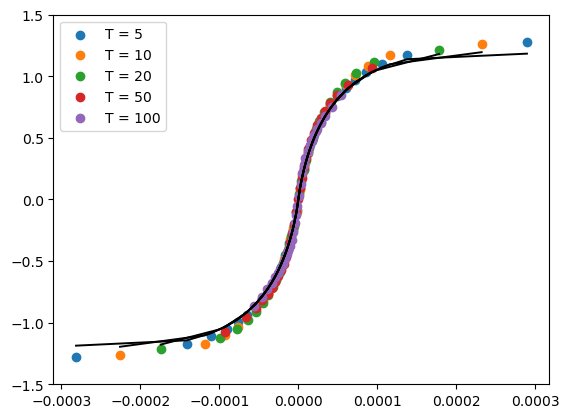

In [18]:
for T, rescaled_param in rescaled_params.items():
    params = rescaled_param.params
    data = rescaled_param.data
    binned_data = bin_data_into_quantiles(data, q=31, duplicates="drop")

    T_values = binned_data['T'].values
    vol_imbalance_values = binned_data['vol_imbalance'].values
    R_values = binned_data['R'].values

    # Orderflow imblance
    orderflow_imbalance = pd.DataFrame({'T': T_values, 'vol_imbalance': vol_imbalance_values})

    # Compute the model prediction
    model_predictions = scaling_law(orderflow_imbalance, *params)

    plt.scatter(vol_imbalance_values, model_predictions, label=f"T = {T}")
    #plt.plot(vol_imbalance_values, model_predictions)
    plt.legend()
    plt.ylim(-1.5, 1.5)

    if T == T:
        plt.plot(vol_imbalance_values, scaling_function(vol_imbalance_values, master_curve_param[2], master_curve_param[3], master_curve_param[4]) * master_curve_param[-1],
                 '-', linewidth=1.4, color='black')
